- title: Do We Over-Use the GEV Distribution?
- date: 2018-09-10
- author: James Doss-Gollin
- category: statistics
- tags: python, English, statistics
- slug: gev-marginal
- summary: Do we sometimes use the GEV when we shouldn't?

In statistical analysis of hydroclimate data we're often interested in fitting distributions to observed variables such as rainfall and streamflow.
The General Extreme Value (GEV) distribution is commonly used because of its "fat" tails, but maybe that's not always necessary.

In the following jupyter notebook I do a simple experiment.
First, I create several time series with random period and phases, which represent the indices of large-scale climate variables (such as ENSO, the PDO, etc).
Second, I draw fake streamflow data using a conditional log-normal model:

$$
\begin{align*}
    \mu &= \mu_0 + X^T \beta \\
    \sigma &= 0.1 \mu \\
    \log Q &\sim \mathcal{N}(\mu, \sigma)
\end{align*}
$$

where $\beta$ are the (also randomly chosen) dependences on the large-scale climate predictors and $X$ is the notation for these predictors.

This is an incredibly over-simplified model and isn't meant to represent all the physics of streamflow -- just the fact that theres is variability present on many timescales (and here there's no trend!)
Interestingly, if you look at the resulting histogram of a long simulation from this model, you would think that a GEV fit was necessary to capture the "fat" tail of this model.
However, the real model doesn't have any GEV dependence -- the "fat tail" comes purely from the dependence on the climate predictors.
It's therefore worth asking ourselves whether we always need to use a GEV distribution (which comes with many problems including difficulty estimating the parameters) or whether we can instead use a simpler statistical distribution (such as the log-normal) plus the use of conditional estimation.
I won't get into the theory in this post, but it's certainly an interesting question!

Here's the analysis:

In [1]:
import numpy as np
from scipy.stats import genextreme as gev
from scipy.stats import norm
from scipy.integrate import trapz
import matplotlib.pyplot as plt
np.random.seed(523)

The question to answer here is whether we can trick ourselves into thinking that data is GEV, when in fact it's log-normal but conditional on several slowly varying predictors.
Here's a function that will give us sinusoidal functions using the model defined above.

In [2]:
def get_sinusoidal_signal(n, amplitude, period, phase, mu0=4.0, coeff_var=0.1):
    time = np.linspace(0, n, n)
    n_predictors = len(amplitude)
    assert len(period) == n_predictors
    assert len(phase) == n_predictors
    predictors = np.array([np.sin(2 * np.pi * time / period[i] + phase[i]) for i in range(n_predictors)]).T
    mu = np.repeat(mu0, time.size)
    for i in range(n_predictors):
        mu += amplitude[i] * predictors[:, i]
    sigma = coeff_var * mu
    sigma[np.where(sigma < 0.1)] = 0.1
    observed = np.exp(np.random.normal(loc=mu, scale=sigma))
    return time,observed

Let's implement this with three signals

In [3]:
n_predictors = 3
time,observed = get_sinusoidal_signal(
    n=100000,
    period=[9, 13, 24],
    amplitude=np.random.normal(loc=0, scale=0.5, size=n_predictors),
    phase=np.random.uniform(low=0, high=2*np.pi, size=n_predictors),
)

Now we will estimate a GEV fit, and a log-normal fit to the data.
(Note that because of how we fit the log-normal, we have to re-scale it).

In [4]:
muhat, sigmahat = norm.fit(np.log(observed))
shapehat, lochat, scalehat = gev.fit(observed)
sflo = np.linspace(0, 600, 1000) # we will make predictions here
norm_prob = norm.pdf(np.log(sflo), loc=muhat, scale=sigmahat)
norm_prob /= trapz(x=sflo, y=norm_prob)
gev_prob = gev.pdf(sflo, shapehat, scale=scalehat, loc=lochat)

/usr/local/miniconda3/envs/jupyter-blog/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


We can plot this fit, as well as the first 1000 years of the time series

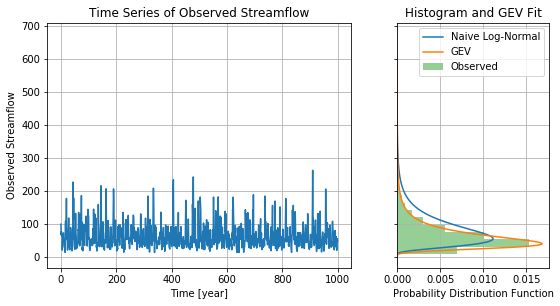

In [5]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4.5), sharey=True, gridspec_kw = {'width_ratios':[2, 1]})
ax = axes[0]
ax.plot(time[0:1000], observed[0:1000])
ax.grid()
ax.set_title('Time Series of Observed Streamflow')
ax.set_xlabel('Time [year]')
ax.set_ylabel('Observed Streamflow')

ax = axes[1]
ax.plot(norm_prob, sflo, label='Naive Log-Normal')
ax.plot(gev_prob, sflo, label='GEV')
ax.hist(observed, orientation="horizontal", density=True, bins=30, alpha=0.5, label='Observed')
ax.grid()
ax.set_xlabel('Probability Distribution Function')
ax.set_title('Histogram and GEV Fit')
ax.legend()

plt.show()

We can see from the plot here that a GEV distribution fits far better than a log-normal distribution here, and might otherwise be inclined to model the data as GEV.
However, this isn't necessarily necessary and may in fact lead to confusion.

While it may not seem like this is a huge deal, inappropriate use of the GEV can lead to poor estimates, particularly as we extrapolate, estimating the probability of floods for which we have fewer and fewer observations.
For example, let's calculate the 99th and 99.9th percentiles of the estimated GEV distribution, as well as the same percentiles of the observed distribution (we have 100000 samples, which should give us reasonable estimates).
These percentiles correspond to the 100- and 1000-year floods.

In [6]:
q99_gev = gev.isf(0.01, shapehat, scale=scalehat, loc=lochat)
q999_gev = gev.isf(0.001, shapehat, scale=scalehat, loc=lochat)
print(f"q99 of GEV:{q99_gev}")
print(f"q999 of GEV: {q999_gev}")
q99_obs = np.percentile(observed, 100*0.99)
q999_obs = np.percentile(observed, 100*0.999)
print(f"q99 of observations: {q99_obs}")
print(f"q99.9 of observations: {q999_obs}")
print(f"ratio of q99 in GEV to observed: {q99_gev / q99_obs}")
print(f"ratio of q999 in GEV to observed: {q999_gev / q999_obs}")

q99 of GEV:242.85588789724653
q999 of GEV: 474.2608694127031
q99 of observations: 212.594974711907
q99.9 of observations: 316.5251547839271
ratio of q99 in GEV to observed: 1.1423406796249387
ratio of q999 in GEV to observed: 1.4983354790125694


In other words, we can see that our GEV model is substantially over-estimating the 100- and 1000-year floods, _in this simple setup_.

Of course, the real question is whether *real-world* data is better represented by a GEV distribution or a condional log-normal distribution.
The answer is probably that it depends on the specific data, and the purpose of this post is just to illustrate how using conditional information can be an alternative to using GEV models.
As always, when working with real data be sure to *check your model* when you make any assumption, including those suggested here!